# Neoclassical growth model in discrete time: Closed Form
## Greenwood-Hercowitz-Huffman preference

###### First written: December 7, 2019
###### Update: December 18, 2019, February 15, 2020

## Key numerical packages
- Gaussian process: `GPyTorch`
- Optimizer: `IPOPT` + `pyipopt`
- Automatic gradient: `PyTorch`
- Z-score (or standardization)

## Introduction

There are two well known closed form solutions for the neoclassical growth model in discrete time. The first, and might be the most well-known example, is discussed, for instance, in Ljungqvist and Sargent (2018). In this notebook, we aim to solve the second example where the social planner maximizes his infinite time horizon utility subject to the budget constraint with full capital depreciation.

\begin{align}
& \max \sum_{t=0}^{\infty}\beta^{t}\ln \left(C_{t} -\psi N_{t}^{\theta}\right) \\
\text{s.t.} \quad & K_{t+1} + C_{t} \leq A K_{t}^{\alpha} N_{t}^{1-\alpha}
\end{align}

where the utility function follows the classical Greenwood–Hercowitz–Huffman preference (Greenwood et al. (1988)).

The above neoclassical growth model is known to have a closed form solution for the capital stock in the next period as well as the optimal consumption policy.

\begin{align}
& K_{t+1} = \alpha \beta A K_{t}^{\alpha} N_{t}^{1-\alpha} \\
& C_{t} = \left(1-\alpha \beta \right) A K_{t}^{\alpha} N_{t}^{1-\alpha}
\end{align}

The aim of this notebook is to numerically approximate the above optimal policy functions by using the Gaussian process regression based on the `GPyTorch` library.

## Analytical solutions

We compute the stationary point at first, then we plot the optimal policy functions.
Before doing so, we import some numerical libraries and define economic parameters. Note that we use the `GPyTorch` library to regress the optimal policy functions based on the Gaussian process and `IPOPT` to solve the system of non-linear equations.

In [1]:
import sys
import warnings
import numpy as np
import torch
import gpytorch
import pyipopt
from scipy.optimize import root  # Find the steady state
# plot
import matplotlib.pyplot as plt
from matplotlib import rc
# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

np.random.seed(123)

print("PyTorch version is {}".format(torch.__version__))
print("GPyTorch version is {}".format(gpytorch.__version__))

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch version is 1.4.0
GPyTorch version is 1.0.1


In [2]:
# --------------------------------------------------------------------------- #
# Parameter setting
# No TFP shock, deterministic model
# --------------------------------------------------------------------------- #
A = 1  # Technology level
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.95  # Discount factor
psi = 0.25  # Coefficient of leisure in the utility function
theta = 1.5  # Elasticity of leisure in the utility function

We compute at first the analytical policy functions of the given model.

In [3]:
# --------------------------------------------------------------------------- #
# Analytical solution
# --------------------------------------------------------------------------- #
def ls_compute(k, A=A, alpha=alpha, psi=psi, theta=theta):
    """ Return the optimal labor supply """
    return (((1-alpha) * A * k**alpha) / (psi*theta))**(1 / (theta+alpha-1))


def kplus_compute_analytic(
        k, A=A, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal capital stock in the next period """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return alpha * beta * A * k**alpha * _ls**(1-alpha)


def c_compute_analytic(k, A=A, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal consumption policy """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return (1 - alpha*beta)*A*k**alpha*_ls**(1-alpha)


def k_infty_compute(k_infty):
    """ Compute the stationary point in capital """
    return k_infty - kplus_compute_analytic(k_infty)


# Find the stationary point
res = root(k_infty_compute, x0=1, method='hybr')
print("Is a root correctly found? {}".format(res.success))
print("Stationary point is {:5f}".format(res.x[0]))

Is a root correctly found? True
Stationary point is 0.162927


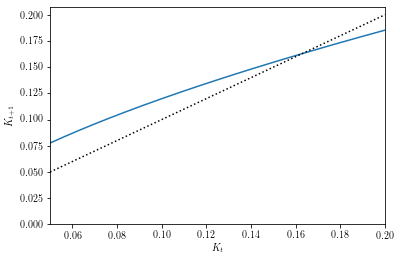

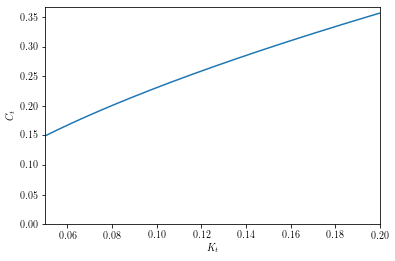

In [4]:
# --------------------------------------------------------------------------- #
# Plot the initial guess
# --------------------------------------------------------------------------- #
kbeg, kend = 0.05, 0.2
grid_plt = 250
kgrid_plt = np.linspace(kbeg, kend, grid_plt)

# Plot the kplus policy function
plt.plot(kgrid_plt, kplus_compute_analytic(kgrid_plt))
plt.plot(kgrid_plt, kgrid_plt, 'k:')
plt.xlabel(r'$K_{t}$')
plt.ylabel(r'$K_{t+1}$')
plt.xlim([kbeg, kend])
plt.ylim([0, None])
plt.show()

# Plot the consumption policy function
plt.plot(kgrid_plt, c_compute_analytic(kgrid_plt))
plt.xlabel(r'$K_{t}$')
plt.ylabel(r'$C_{t}$')
plt.xlim([kbeg, kend])
plt.ylim([0, None])
plt.show()

## Time iteration collocation with the Gaussian process

Here we aim to numerically solve the neoclassical growth model with the Gaussian process regression. Firstly, we solve the model for the first-order conditions:

\begin{align}
& \lambda_{t} - \beta \lambda_{t+1} \alpha A K_{t+1}^{\alpha-1}N_{t+1}^{1-\alpha} = 0 \label{eq:foc_kplus}\\
& A K_{t}^{\alpha}N_{t}^{1-\alpha} - C_{t} - K_{t+1} = 0 \label{eq:foc_rsc}
\end{align}

where $\lambda_{t}$ is the Lagrange multiplier associated with the resource constraint. By substituting \eqref{eq:foc_rsc} to \eqref{eq:foc_kplus}, our task is to solve the equation for the Lagrange multiplier. Note that the resource constraint is always binding as the marginal utility is positive, the corresponding Lagrange multiplier $\lambda_{t}$ always takes a positive value.

Hereafter, we solve the system of non-linear equation by using the time iteration collocation.We at first instantiate and initialize the Gaussian process regressor.

In [5]:
# --------------------------------------------------------------------------- #
# Gaussian process, training and test dataset
# --------------------------------------------------------------------------- #
num_train = 25  # Number of training samples
num_test = 1000  # Number of test samples

# Training datasets, assuming a uniform distribution
train_x = torch.linspace(kbeg, kend, num_train, dtype=torch.float64)
train_y_kplus = train_x

# Test datasets
test_x = torch.linspace(kbeg, kend, num_test, dtype=torch.float64)

### Gaussian process regression

We use the RBF kernel and instantiate the Gaussian process.

In [6]:
# --------------------------------------------------------------------------- #
# Train the model hyperparameters
# --------------------------------------------------------------------------- #
def TrainGPModel(
        train_X, train_y_kplus, learning_rate, training_iter, print_skip):
    """
    Train the Gaussian process and optimize the model hyperparameters
    Use the torch.optim.Adam optimizer
    train_X.shape == [n, d]
    train_y_kplus.shape == [n]
    train_y_kplus is z-scored
    """
    # ----------------------------------------------------------------------- #
    # Instantiate and initialize the Gaussian process
    # ----------------------------------------------------------------------- #
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    gp_kplus = ExactGPModel(train_X, train_y_kplus, likelihood)

    # ----------------------------------------------------------------------- #
    # Find the optimal model hyperparameters
    # Use the Adam optimizer
    # ----------------------------------------------------------------------- #
    gp_kplus.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam([
        # Includes GaussianLikelihood parameters
        {'params': gp_kplus.parameters()}, ], lr=learning_rate)

    # Loss for GP - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_kplus)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = gp_kplus(train_X)
        # Calculate the  loss and backprop gradients
        loss = - mll(output, train_y_kplus)
        loss.backward()
        if print_skip != 0 and (i+1) % print_skip == 0:
            print(
                'Iter %d/%d - Loss: %.3f - lengthscale: %.3f - noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    gp_kplus.covar_module.base_kernel.lengthscale.item(),
                    gp_kplus.likelihood.noise.item()
                )
            )
        optimizer.step()

    return gp_kplus, likelihood

then we take the z-score of outputs.

In [7]:
def mean_std(train_y):
    """
    Compute the mean and the standard deviation of the output train_y
    train_y: Original output (torch.tensor)
    return mean (torch.tensor) and standard deviation (torch.tensor)
    """
    return train_y.mean(-1, keepdim=True), train_y.std(-1, keepdim=True)


def z_score(train_y):
    """
    Take a z-score (standardaization)
    train_y: Original output (torch.tensor)
    return zscored output (torch.tensor)
    """
    train_y_mean, train_y_std = mean_std(train_y)
    return (train_y - train_y_mean) / train_y_std


def scale_back(train_y, train_y_zscore):
    """
    Scale back to the original output
    train_y: Original output (torch.tensor)
    train_y_zscore: z-score output (torch.tensor)
    return scaled-backed output (torch.tensor)
    """
    train_y_mean, train_y_std = mean_std(train_y)
    return train_y_zscore * train_y_std + train_y_mean

We optimize the hyperparameters by the `PyTorch`'s gradient decent optimizer `adam`.

In [8]:
train_y_kplus_zscore = z_score(train_y_kplus)
gp_kplus, likelihood = TrainGPModel(
    train_x, train_y_kplus_zscore, learning_rate=0.1, training_iter=1000,
    print_skip=50)

Iter 50/1000 - Loss: -0.859 - lengthscale: 0.152 - noise: 0.011
Iter 100/1000 - Loss: -2.562 - lengthscale: 0.298 - noise: 0.000
Iter 150/1000 - Loss: -2.786 - lengthscale: 0.219 - noise: 0.000
Iter 200/1000 - Loss: -2.817 - lengthscale: 0.252 - noise: 0.000
Iter 250/1000 - Loss: -2.834 - lengthscale: 0.301 - noise: 0.000
Iter 300/1000 - Loss: -2.862 - lengthscale: 0.448 - noise: 0.000
Iter 350/1000 - Loss: -2.876 - lengthscale: 0.462 - noise: 0.000
Iter 400/1000 - Loss: -2.886 - lengthscale: 0.477 - noise: 0.000
Iter 450/1000 - Loss: -2.894 - lengthscale: 0.490 - noise: 0.000
Iter 500/1000 - Loss: -2.900 - lengthscale: 0.501 - noise: 0.000
Iter 550/1000 - Loss: -2.904 - lengthscale: 0.511 - noise: 0.000
Iter 600/1000 - Loss: -2.908 - lengthscale: 0.520 - noise: 0.000
Iter 650/1000 - Loss: -2.912 - lengthscale: 0.528 - noise: 0.000
Iter 700/1000 - Loss: -2.915 - lengthscale: 0.535 - noise: 0.000
Iter 750/1000 - Loss: -2.917 - lengthscale: 0.543 - noise: 0.000
Iter 800/1000 - Loss: -2.9

Then plot the posterior distributions.

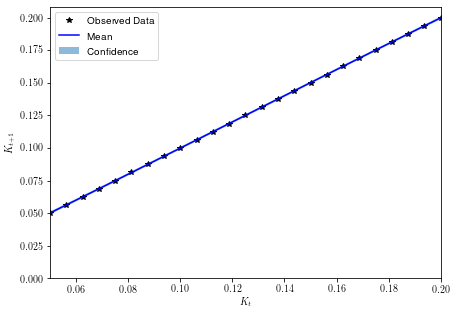

In [9]:
# --------------------------------------------------------------------------- #
# Plot the posterior distirubtion with the hyperparameters optimization
# --------------------------------------------------------------------------- #
# Get into evaluation (predictive posterior) mode
gp_kplus.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_x = torch.linspace(kbeg, kend, 50, dtype=torch.float64)
    pred_kplus = likelihood(gp_kplus(plot_x))

# sys.exit(0)
with torch.no_grad():
    # Initialize plot for kplus
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # Get upper and lower confidence bounds
    lower, upper = pred_kplus.confidence_region()
    lower = scale_back(train_y_kplus, lower)
    upper = scale_back(train_y_kplus, upper)
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y_kplus.numpy(), 'k*')
    # Plot predictive means as blue line
    pred_kplus = scale_back(train_y_kplus, pred_kplus.mean)
    ax.plot(plot_x.numpy(), pred_kplus.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([kbeg, kend])
    ax.set_ylim([0, None])
    ax.set_xlabel(r"$K_{t}$")
    ax.set_ylabel(r"$K_{t+1}$")
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

## Define the equilibrium conditions

In [10]:
# --------------------------------------------------------------------------- #
# Equilibrium conditions
# --------------------------------------------------------------------------- #
def euler(x0, k, gp_kplus, likelihood, train_y_org):
    """
    Set of a non-linear equilibrium condition solved by IPOPT + pyipopt
    Jacobian is supplied via the automatic gradient of PyTorch
    Hessian is approximated by the IPOPT's limited memory option
    x0: Starting values for the optimization
    k: Current capital state
    gp_kplus, likelihood: Gaussian process regression model (GPyTorch)
    train_y_org: Original traininig outputs because the output is z-scored
    x[0]: Capital stock in the next period
    """

    nvar = 1  # Number of a variable

    # All of plicies are assumed to be non-negative
    x_L = np.zeros(nvar, dtype=np.float64)
    x_U = np.ones(nvar, dtype=np.float64) * 1000

    def eval_f(x):
        """ Dummy objective function """
        assert len(x) == nvar
        return 0

    def eval_grad_f(x):
        """ Gradient of the dummy objective function """
        assert len(x) == nvar
        grad_f = np.zeros(nvar, dtype=np.float64)
        return grad_f

    def ls_compute(k):
        """ Return the optimal labor supply """
        return (((1-alpha) * A * k**alpha) / (psi*theta))**(
            1 / (theta+alpha-1))

    # Labor supply today
    ls = ls_compute(k)

    ncon = nvar  # Number of a constraint

    """ Equilibrium condition
    g0: Euler equation wrt. k_{t+1}
    """

    g_L = np.zeros(ncon, dtype=np.float64)
    g_U = g_L

    nnzj = int(nvar * ncon)  # Number of (possibly) non-zeros in Jacobian
    nnzh = int((nvar**2 - nvar) / 2 + nvar)  # Number of non-zeros in Hessian

    def eval_g_tensor(x):
        """
        The system of non-linear equilibrium conditions
        PyTorch version
        """
        assert len(x) == nvar

        # Consumption today
        con = A * k**alpha * ls**(1-alpha) - x[0]

        # Labor supply tomorrow
        ls_plus = ls_compute(x[0])

        # Capital stock in the day after tomorrow
        if type(x) is torch.Tensor:
            k_plusplus = likelihood(gp_kplus(x[None, :][0])).mean
        elif type(x) is np.ndarray:
            k_plusplus = likelihood(gp_kplus(torch.tensor(
                [x[0]], dtype=torch.float64)[None, :])).mean
        else:
            raise TypeError("x shold be either torch.Tensor or np.ndarray")

        # Scale back to the original output range
        k_plusplus = scale_back(train_y_org, k_plusplus)

        # Consumption tomorrow
        con_plus = A * x[0]**alpha * ls_plus**(1-alpha) - k_plusplus

        # ------------------------------------------------------------------- #
        # Euler equation
        # ------------------------------------------------------------------- #
        g0 = 1/con - beta * alpha * 1/con_plus * A * x[0]**(alpha-1) \
            * ls_plus**(1-alpha)

        return [g0]

    def eval_g_numpy(x):
        """ Convert from Tensor to numpy so that IPOPT can handle """
        return np.array(eval_g_tensor(x), dtype=np.float64)

    def eval_jac_g(x, flag):
        """
        Jacobian of the system of non-linear equilibrium conditions
        Automatic differenciation provided by PyTorch
        """
        assert len(x) == nvar

        row_idx = np.empty(nnzj, dtype=int)  # Row index
        col_idx = np.empty(nnzj, dtype=int)  # Column index

        # Jacobian matrix structure
        if flag:
            for i in range(ncon):
                for j in range(nvar):
                    row_idx[j + i * nvar] = i
                    col_idx[j + i * nvar] = j

            return (row_idx, col_idx)

        else:
            # Automatic gradient by PyTorch
            assert len(x) == nvar
            x_grad = torch.tensor(x, requires_grad=True)
            jac = []
            for i in range(ncon):
                grad, = torch.autograd.grad(eval_g_tensor(x_grad)[i], x_grad)
                jac.append(grad)
            return torch.stack(jac).flatten().numpy()

    # ----------------------------------------------------------------------- #
    # Define a NLP model
    # ----------------------------------------------------------------------- #
    pyipopt.set_loglevel(0)  # Let IPOPT quite

    neoclassical = pyipopt.create(
        nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f,
        eval_g_numpy, eval_jac_g)
    neoclassical.str_option("linear_solver", "ma57")
    neoclassical.str_option("hessian_approximation", "limited-memory")
    # neoclassical.str_option("derivative_test", "first-order")  # Pass!
    neoclassical.int_option("print_level", 1)

    xstar, zl, zu, constraint_multipliers, obj, status = neoclassical.solve(x0)

    if status not in [0, 1]:
        warnings.warn(
            "IPOPT fails to solve the system of non-linear equations. "
            "Use the starting value as the solution instead.")
        xstar = x0
    return xstar

Then we numerically approximate the policy function using the time iteration collocation with the Gaussian process.

In [11]:
# --------------------------------------------------------------------------- #
# Time iteration collocation with the Gaussian process regression
# --------------------------------------------------------------------------- #
def time_iter_gp(num_train, training_iter):
    """
    Time iteration collocation with the Gaussian process regression
    num_train: Number of training examples
    training_iter: Number of training iterations
    """
    num_iter = 500  # Maximum number of time iterations
    epsilons = []  # Track the approximation error
    epsilon_tol = 1e-6  # Convergence tolrance

    # ----------------------------------------------------------------------- #
    # Generate a training dataset, uniform distribution
    # ----------------------------------------------------------------------- #
    train_x = torch.linspace(kbeg, kend, num_train, dtype=torch.float64)
    train_y_kplus = train_x  # Initial guess
    # Z-score
    train_y_kplus_zscore = z_score(train_y_kplus)
    # ----------------------------------------------------------------------- #
    # Instantiate and train the Gaussian processes with the z-scored output
    # ----------------------------------------------------------------------- #
    gp_kplus, likelihood = TrainGPModel(
        train_x, train_y_kplus_zscore, learning_rate=0.1, training_iter=1000,
        print_skip=50)

    # sys.exit(0)
    # ----------------------------------------------------------------------- #
    # Time iteration collocation
    # ----------------------------------------------------------------------- #
    for n in range(1, num_iter+1):
        # Get into evaluation (predictive posterior) mode
        gp_kplus.eval()
        likelihood.eval()

        # Keep the original value range
        train_y_kplus_org = train_y_kplus

        # Starting value retliving from the previous optimization
        x0 = train_y_kplus.numpy()[:, None]

        # Track the optimal policies
        train_y_kplus = np.empty_like(train_y_kplus)

        for idx, k in enumerate(train_x.numpy()):
            # For each state, solve the system of non-linear equations
            xstar = euler(x0[idx], k, gp_kplus, likelihood, train_y_kplus_org)
            # Track the optimal policies
            train_y_kplus[idx] = xstar
            # sys.exit(0)
        # ------------------------------------------------------------------- #
        # Train the Gaussian process with the optimal policy
        # ------------------------------------------------------------------- #
        # Training data before taking z-score
        train_y_kplus = torch.from_numpy(train_y_kplus)
        # Z-scored output
        train_y_kplus_zscore = z_score(train_y_kplus)
        # Training
        gp_kplus_updated, likelihood_updated = TrainGPModel(
            train_x, train_y_kplus_zscore, learning_rate=0.1,
            training_iter=1000, print_skip=0)

        # ------------------------------------------------------------------- #
        # Approximation error analysis
        # Update the policy functions for the next iteration
        # ------------------------------------------------------------------- #
        # Switch to the evaluation mode
        gp_kplus.eval()
        gp_kplus_updated.eval()
        likelihood.eval()
        likelihood_updated.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = likelihood(gp_kplus(test_x))
            pred_update = likelihood_updated(gp_kplus_updated(test_x))

            epsilon = np.max(np.abs(
                pred.mean.numpy() - pred_update.mean.numpy()))
        epsilons.append(epsilon)  # Track the history of epsilon

        if n % 1 == 0:
            print('Iteration: {}, Approximation error: {:.3e}'.format(
                n, epsilons[-1]))

        if epsilons[-1] < epsilon_tol:
            # Terminate the time iteration and save the optimal surrogates
            gp_kplus_star = gp_kplus_updated
            likelihood_star = likelihood_updated
            train_y_kplus_last = train_y_kplus_org
            print("Time iteration collocation is terminated successfuly with "
                  "{} iterations".format(n))
            break  # Terminate the iteration

        else:
            # Update the GP with the surrogates
            gp_kplus = gp_kplus_updated
            likelihood = likelihood_updated
            
    return epsilons, gp_kplus_star, likelihood_star, train_y_kplus_last

Now suppose that there are 25 training samples:

In [12]:
%timeit
# --------------------------------------------------------------------------- #
# num_train = 30, training_iter = 250
# --------------------------------------------------------------------------- #
epsilons, gp_kplus_star, likelihood_star, train_y_kplus_last \
    = time_iter_gp(25, 250)

Iter 50/1000 - Loss: -0.859 - lengthscale: 0.152 - noise: 0.011
Iter 100/1000 - Loss: -2.562 - lengthscale: 0.298 - noise: 0.000
Iter 150/1000 - Loss: -2.786 - lengthscale: 0.219 - noise: 0.000
Iter 200/1000 - Loss: -2.817 - lengthscale: 0.252 - noise: 0.000
Iter 250/1000 - Loss: -2.834 - lengthscale: 0.301 - noise: 0.000
Iter 300/1000 - Loss: -2.862 - lengthscale: 0.448 - noise: 0.000
Iter 350/1000 - Loss: -2.876 - lengthscale: 0.462 - noise: 0.000
Iter 400/1000 - Loss: -2.886 - lengthscale: 0.477 - noise: 0.000
Iter 450/1000 - Loss: -2.894 - lengthscale: 0.490 - noise: 0.000
Iter 500/1000 - Loss: -2.900 - lengthscale: 0.501 - noise: 0.000
Iter 550/1000 - Loss: -2.904 - lengthscale: 0.511 - noise: 0.000
Iter 600/1000 - Loss: -2.908 - lengthscale: 0.520 - noise: 0.000
Iter 650/1000 - Loss: -2.912 - lengthscale: 0.528 - noise: 0.000
Iter 700/1000 - Loss: -2.915 - lengthscale: 0.535 - noise: 0.000
Iter 750/1000 - Loss: -2.917 - lengthscale: 0.543 - noise: 0.000
Iter 800/1000 - Loss: -2.9

Finally we plot the convergence process as well as the posterior distributions. We compare the numerically approximated policy functions with the analytical solutions.

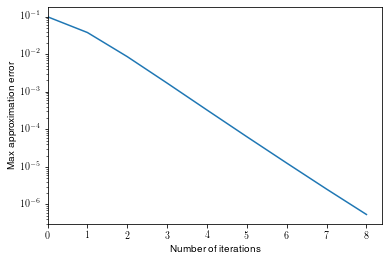

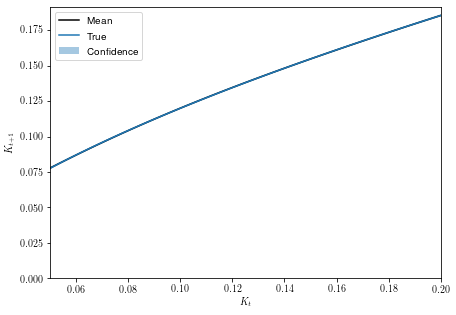

In [13]:
# --------------------------------------------------------------------------- #
# Plot
# --------------------------------------------------------------------------- #
# Approximation error
plt.plot(epsilons)
plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel("Max approximation error")
plt.xlim([0, None])
plt.show()

# Turn on the evaluation mode to plot the policy functinos
gp_kplus_star.eval()
likelihood_star.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_x = torch.linspace(kbeg, kend, 50, dtype=torch.float64)
    pred = likelihood_star(gp_kplus_star(plot_x))
    kplus_star_mu = pred.mean  # Z-scored value
    kplus_star_mu = scale_back(train_y_kplus_last, kplus_star_mu)
    kplus_lower, kplus_upper = pred.confidence_region()  # Z-scored value
    kplus_lower = scale_back(train_y_kplus_last, kplus_lower)
    kplus_upper = scale_back(train_y_kplus_last, kplus_upper)

with torch.no_grad():
    # Initialize plot for kplus_star
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # Plot the predicted mean
    ax.plot(plot_x.numpy(), kplus_star_mu, 'k-', label=r'Mean')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), kplus_lower.numpy(), kplus_upper.numpy(),
                    alpha=0.4, label=r'Confidence')
    ax.plot(plot_x.numpy(), kplus_compute_analytic(plot_x.numpy()),
            label=r'True')
    ax.set_xlim([kbeg, kend])
    ax.set_ylim([0, None])
    ax.set_xlabel(r"$K_{t}$")
    ax.set_ylabel(r"$K_{t+1}$")
    ax.legend(loc='best')
    plt.show()